<a href="https://colab.research.google.com/github/abou-zithar/Predicting-disaster-tweets-using-LSTM/blob/main/Amit_final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [120]:
import pandas as pd
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns


In [121]:
from google.colab import drive

In [122]:
# to remove the warnings from the code 
import warnings
warnings.filterwarnings('ignore')

In [123]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


- id => a unique identifier for each tweet
- text => the text of the tweet
- location => the location the tweet was sent from (may be blank)
- keyword => a particular keyword from the tweet (may be blank)
- target => in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

### Load the dataset

In [124]:
train_data =pd.read_csv('/content/drive/MyDrive/Amit final project/train.csv')

In [125]:
test_data =pd.read_csv('/content/drive/MyDrive/Amit final project/test.csv')

# Check head and info of the data

In [126]:
train_data

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [127]:
test_data

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [128]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [129]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


My Observations:
- first the data was 10875 row and split to 30% test and 70% train 
- both has nulls we will see how to work with these nulls
- the nulls is normal in the two feature as the description said 


# trainning data

### Is there a missing data [how many and the precentage if there]?

In [130]:
# function to get missing value from the data
def get_missing_prec(names_list,data):
  data_missing_list=[]
  for col_name in names_list:
    data_missing_list.append(data[col_name].isna().sum()/data.shape[0]*100)
  return data_missing_list


In [131]:
data_col_list=['keyword','location','text']
train_data_missing_list=get_missing_prec(data_col_list,train_data)

In [132]:
print('train data missing precentage')
print('---------')
print(data_col_list)
print(train_data_missing_list)

train data missing precentage
---------
['keyword', 'location', 'text']
[0.8012610009194797, 33.27203467752528, 0.0]


In [133]:
test_data_missing_list=get_missing_prec(data_col_list,test_data)

In [134]:
print('test data missing precentage')
print('---------')
print(data_col_list)
print(test_data_missing_list)

test data missing precentage
---------
['keyword', 'location', 'text']
[0.796812749003984, 33.86454183266932, 0.0]


### How many data in each class?

In [135]:
train_data['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

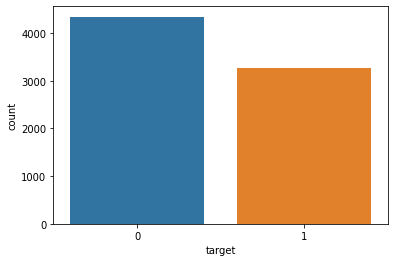

In [136]:
sns.countplot(train_data['target'])

# Get the top 15 locations of the data

In [137]:
train_data['location'].value_counts()[:15]

USA                104
New York            71
United States       50
London              45
Canada              29
Nigeria             28
UK                  27
Los Angeles, CA     26
India               24
Mumbai              22
Washington, DC      21
Kenya               20
Worldwide           19
Australia           18
Chicago, IL         18
Name: location, dtype: int64

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 <a list of 15 Text major ticklabel objects>)

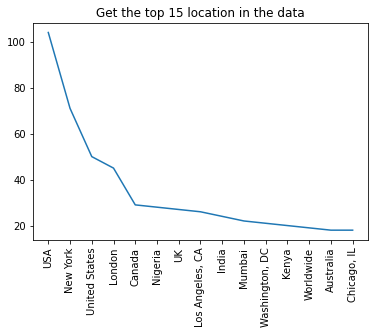

In [138]:
plt.title('Get the top 15 location in the data')
plt.plot(train_data['location'].value_counts()[:15])
plt.xticks( rotation='vertical')

# Get the top 15 keyword in the data

In [139]:
train_data['keyword'].value_counts()[:15]

fatalities     45
deluge         42
armageddon     42
sinking        41
damage         41
harm           41
body%20bags    41
outbreak       40
evacuate       40
fear           40
collided       40
siren          40
twister        40
windstorm      40
sinkhole       39
Name: keyword, dtype: int64

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 <a list of 15 Text major ticklabel objects>)

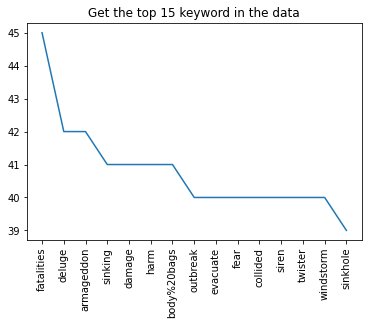

In [140]:
plt.title('Get the top 15 keyword in the data')
plt.plot(train_data['keyword'].value_counts()[:15])
plt.xticks(rotation=90)

# Get each word in text feature

In [141]:
# split the text to words
def get_words(val,df):
    words = []
    for text in df[df["target"]==val]["text"].str.split():
        for subtext in text:
            words.append(subtext)
    return words

postive_words = get_words(1,train_data)
negative_words = get_words(0,train_data)

In [142]:
words=postive_words+negative_words

# include stopwords

In [143]:
import nltk
from nltk.corpus import stopwords
from collections import Counter
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [144]:
stop_words = stopwords.words('english')

In [145]:
#function to get the most comman word in the dataset 
def get_commans_words(words,stop_words):
  common_words = []
  comman_stop_words=[]
  
  for word in words:
    if word not in stop_words:
      common_words.append(word)  
    else:
      comman_stop_words.append(word)
  return comman_stop_words,common_words


In [146]:

comman_stop_words,common_words = get_commans_words(words, stop_words)
#-----------------------------------------------------------------       
counter_list = Counter(common_words)
counter_list_stop_words = Counter(comman_stop_words)

In [147]:
type(counter_list)

collections.Counter

In [148]:
word, word_count = map(list, zip(*counter_list.most_common()[:15]))
word_stop, word_stop_count = map(list, zip(*counter_list_stop_words.most_common()[:15]))

# visualization to the last two questions

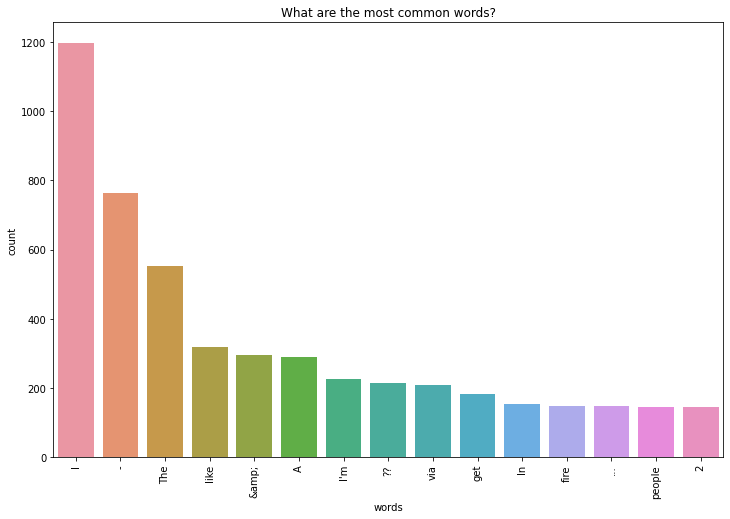

In [149]:
plt.figure(figsize=(12,8))
sns.barplot(y=word_count, x=word)
plt.xticks(rotation=90)
plt.title("What are the most common words?")
plt.xlabel("words")
plt.ylabel("count")
plt.show()

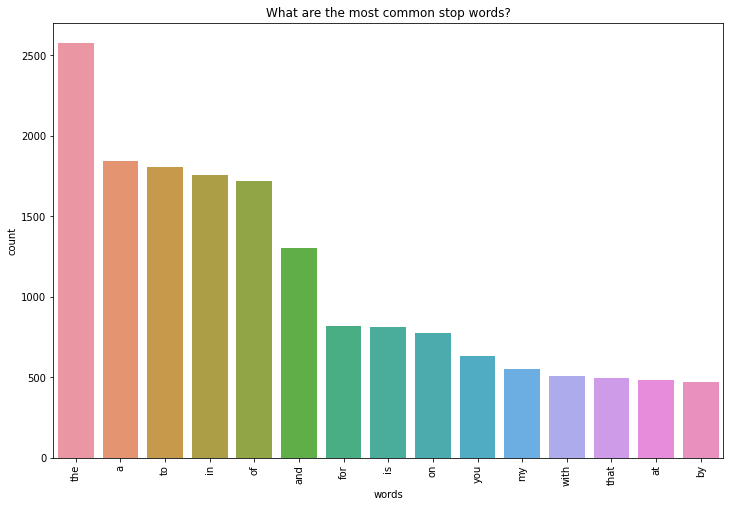

In [150]:
plt.figure(figsize=(12,8))
sns.barplot(y=word_stop_count, x=word_stop)
plt.xticks(rotation=90)
plt.title("What are the most common stop words?")
plt.xlabel("words")
plt.ylabel("count")
plt.show()

In [151]:

x_train =pd.read_csv('/content/drive/MyDrive/Amit final project/train.csv',usecols=["id", "text", "target"])
x_test = pd.read_csv('/content/drive/MyDrive/Amit final project/test.csv', usecols=["id", "text"])

y_train = x_train['target'].values

# NLP Preprocessing

In [152]:
x_train.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [153]:
import re

In [154]:
# clean the tweets from all the signs
def cleanText(texts):
  result=[]
  for text in texts:
    text = re.sub(r'@\w*','',text) #Remove Mentions
    text = re.sub(r'https?:\S*','',text) #Remove Links
    text = re.sub(r'\d*','',text) #Remove Numbers
    text = re.sub(r'\W+',' ',text) #Remove Symbols
    result.append(text)

  return result

In [155]:
x_train_text=cleanText(x_train['text'])
x_test_text=cleanText(x_test['text'])


# Tokenizer

In [156]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [157]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(x_train_text)
X_train =tokenizer.texts_to_sequences(x_train_text)

# every word get a value which represent the importance of this word

In [158]:
tokenizer.fit_on_texts(x_test_text)
X_test =tokenizer.texts_to_sequences(x_test_text)

In [159]:
print(X_train[0])

[112, 4325, 24, 1, 834, 5, 20, 248, 137, 1561, 4326, 85, 40]


# Padding_sequence

In [160]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [161]:
X_train=pad_sequences(X_train,maxlen=25)
X_test=pad_sequences(X_test,maxlen=25)

In [162]:
X_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,  112, 4325,   24,    1,  834,    5,   20,  248,  137, 1561,
       4326,   85,   40], dtype=int32)

In [163]:
from sklearn.model_selection import train_test_split

In [164]:
x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [165]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,GlobalAveragePooling1D,LSTM,Bidirectional,Dropout 

In [166]:
model=Sequential()
model.add(Embedding(len(tokenizer.word_index)+1,15,input_length=25))
model.add(LSTM(64, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 25, 15)            260040    
                                                                 
 lstm_10 (LSTM)              (None, 64)                20480     
                                                                 
 dense_27 (Dense)            (None, 16)                1040      
                                                                 
 dropout_9 (Dropout)         (None, 16)                0         
                                                                 
 dense_28 (Dense)            (None, 1)                 17        
                                                                 
Total params: 281,577
Trainable params: 281,577
Non-trainable params: 0
_________________________________________________________________


In [167]:
model.compile(optimizer='RMSprop', loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), shuffle=True, epochs=10)

Epoch 1/10
191/191 [==============================] - 6s 20ms/step - loss: 0.6602 - accuracy: 0.6140 - val_loss: 0.5768 - val_accuracy: 0.7492
Epoch 2/10
191/191 [==============================] - 4s 19ms/step - loss: 0.5128 - accuracy: 0.7841 - val_loss: 0.4803 - val_accuracy: 0.7846
Epoch 3/10
191/191 [==============================] - 4s 19ms/step - loss: 0.5648 - accuracy: 0.8261 - val_loss: 0.4547 - val_accuracy: 0.8063
Epoch 4/10
191/191 [==============================] - 4s 18ms/step - loss: 0.4044 - accuracy: 0.8468 - val_loss: 0.4732 - val_accuracy: 0.8030
Epoch 5/10
191/191 [==============================] - 4s 18ms/step - loss: 0.3627 - accuracy: 0.8593 - val_loss: 0.5363 - val_accuracy: 0.7577
Epoch 6/10
191/191 [==============================] - 4s 19ms/step - loss: 0.3541 - accuracy: 0.8744 - val_loss: 0.4816 - val_accuracy: 0.8011
Epoch 7/10
191/191 [==============================] - 4s 19ms/step - loss: 0.3401 - accuracy: 0.8847 - val_loss: 0.4656 - val_accuracy: 0.8011

In [168]:
def plot(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for i in range(2):
        ax[i].plot(history.history[arr[i][0]])
        ax[i].plot(history.history[arr[i][1]])
        ax[i].legend([arr[i][0], arr[i][1]],fontsize=18)
        ax[i].set_xlabel('epochs ',fontsize=16)
        if i == 1:
          ax[i].set_ylabel('accuracy',fontsize=16)
        else:
          ax[i].set_ylabel('loss',fontsize=16)
        ax[i].set_title(arr[i][0] + ' X ' + arr[i][1],fontsize=16)

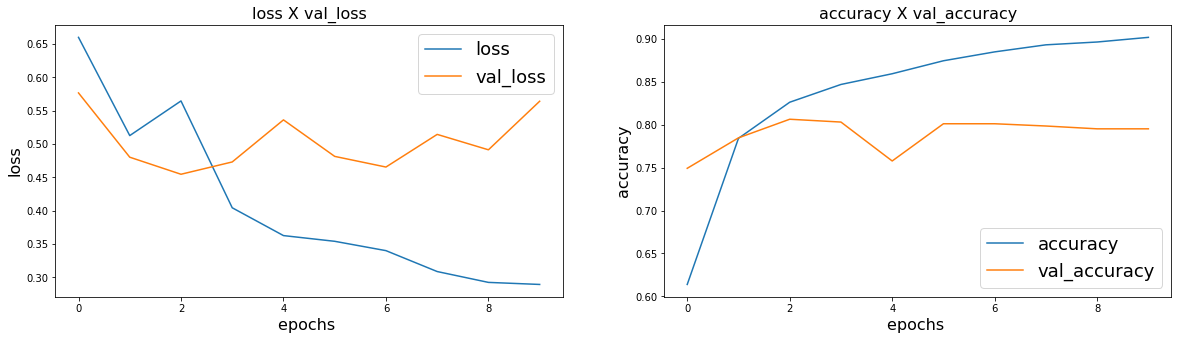

In [169]:
plot(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

In [170]:
model.evaluate(x_val,y_val)

48/48 [==============================] - 0s 6ms/step - loss: 0.5643 - accuracy: 0.7951


[0.5643237233161926, 0.7951411604881287]

In [171]:
Y_test=model.predict(X_test).flatten()

In [172]:
Y_test

array([0.07045075, 0.11349934, 0.2203112 , ..., 0.08132306, 0.16651645,
       0.18865028], dtype=float32)

In [173]:
def get_the_predict (list1):
  new_list=[]
  for i in range(len(list1)):
    if list1[i]>.5:
      new_list.append(1)
    else:
      new_list.append(0)
  return new_list



In [174]:
Y_test=np.array(get_the_predict(Y_test))

In [175]:
predictions = np.where(Y_test >= 0.9,1,0)
test_id=test_data['id']

In [176]:
predictions

array([0, 0, 0, ..., 0, 0, 0])

In [177]:
output = pd.DataFrame({'id':test_id,'target':list(predictions)})
output.tail(100)

,id,target
3163,10495,0
3164,10497,1
3165,10501,1
3166,10504,1
3167,10507,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


In [178]:
output.to_csv('output.csv', sep=',', encoding='utf-8')

# Save model


In [179]:
model.save("/content/drive/MyDrive/Amit final project/NLP_tweetes_model.h5")